https://www.tensorflow.org/text/tutorials/text_classification_rnn

In [ ]:
import json
import os
import sys

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ.pop('TF_CONFIG', None)

if '.' not in sys.path:
    sys.path.insert(0, '.')

In [ ]:
!pip install tf-nightly

In [ ]:
tf_config = {
    'cluster': {
        'worker': ['localhost:12345', 'localhost:23456']
    },
    'task': {'type': 'worker', 'index': 0}
}

json.dumps(tf_config)

In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf

import keras
from keras.utils import Sequence
from keras.utils import to_categorical

import matplotlib.pyplot as plt

import pickle

In [2]:
NUM_CATEGORY = 8
BATCH_SIZE = 16
EPOCHS = 20
SAMPLE_SIZE = 10000

VOCAB_SIZE = 1000 # Maximum vocab size.
MAX_LEN = 200  # Sequence length to pad the outputs to.
MAX_FEATURES = 3000

In [3]:
# df = pd.read_csv("dataset_final_stem_only_eng.csv")
df = pd.read_csv("3_Preprocessing/dataset_lemmatized.csv")

# df['type'].unique()
# len(df['type'].unique())
print(df.shape)
df.head()

(40371, 7)


,index,name,link,lang_eng,valid_dir,value,type
0,0,Australian National University,http://www.anu.edu.au/,1,1,anu newsroom anu study anu research innovation...,Education
1,1,Monash University,http://www.monash.edu/,1,1,monash university one top university australia...,Education
2,2,University of Queensland,http://www.uq.edu.au/,1,1,university queensland university queensland co...,Education
3,3,Macquarie University,http://mq.edu.au/,1,1,macquarie university tertiary education curren...,Education
4,4,UNSW Sydney,https://www.unsw.edu.au/,1,1,unsw sydney one best university australia unsw...,Education


In [4]:
df["type"].unique()

array(['Education', 'Nonprofit', 'Facility', 'Government', 'Company',
       'Healthcare', 'Other', 'Archive'], dtype=object)

In [5]:
# sample_df = df[(df["type"] == "Company") | (df["type"] == "Education")].sample(n=SAMPLE_SIZE)
# sample_df = df[(df["type"] == "Company") | (df["type"] == "Education")]
sample_df = df.sample(SAMPLE_SIZE)
# sample_df = df
sample_df.head(5)

,index,name,link,lang_eng,valid_dir,value,type
38825,97549,WayRay (Russia),https://wayray.com/,1,1,wayray wayray deep reality display wayray wayr...,Company
17605,43804,Guided Systems Technologies (United States),http://guidedsys.com/,1,1,guided system technology guided system technol...,Company
13912,35428,Chinese Historical Society of America,http://chsa.org/,1,1,homepage chinese historical society america ch...,Archive
24352,62731,Hinton Area Foundation,http://hintonareafoundation.org/,1,1,home hinton area foundation home hinton area f...,Nonprofit
24517,62968,Antara Foundation,http://www.antarafoundation.org/,1,1,home page antara foundation home page antara f...,Nonprofit


In [6]:
print(sample_df['type'].unique())
print(sample_df.shape)

['Company' 'Archive' 'Nonprofit' 'Other' 'Government' 'Education'
 'Healthcare' 'Facility']
(10000, 7)


# Tensorflow Keras CountVectorizer layer (LSTM)

In [7]:
from sklearn.model_selection import train_test_split

X = sample_df["value"]
y = sample_df["type"]
y = to_categorical(np.asarray(y.factorize()[0]), num_classes=NUM_CATEGORY)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.25)

In [8]:
# Create the layer
vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=MAX_LEN
)
vectorize_layer.adapt(np.array(X_train).flatten())

In [9]:
vocab = np.array(vectorize_layer.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'skip', 'content', 'page', 'found', 'main', 'home',
       'public', 'search', 'navigation', 'university', 'dtd', 'health',
       'contact', 'research', 'menu', 'service', 'foundation', 'xhtml'],
      dtype='<U23')

In [12]:
# LSTM model
model1 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1,), dtype=tf.string),
    vectorize_layer,
    tf.keras.layers.Embedding(
        input_dim=len(vectorize_layer.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    # tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(8, activation="softmax")
])
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 200)              0         
 torization)                                                     
                                                                 
 embedding_1 (Embedding)     (None, 200, 64)           64000     
                                                                 
 bidirectional (Bidirectiona  (None, 200, 128)         66048     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                        

In [ ]:
strategy = tf.distribute.MultiWorkerMirroredStrategy()

with strategy.scope():
    model1.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                   optimizer=tf.keras.optimizers.Adam(1e-4),
                   # metrics=[tf.keras.metrics.CategoricalCrossentropy()])
                   metrics=[tf.keras.metrics.CategoricalAccuracy()])

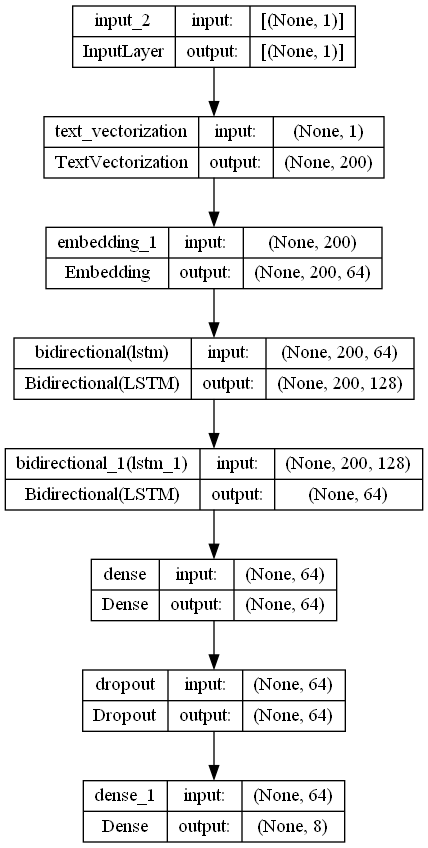

In [13]:
from keras.utils import plot_model
plot_model(model1, show_shapes=True, show_layer_names=True)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
# simple early stopping
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
checkpoint = ModelCheckpoint("best_model", monitor="val_categorical_accuracy", verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model1.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=EPOCHS, validation_steps=30, callbacks=[callbacks_list], verbose=1)

Epoch 1/20


C:\Users\Martin\DataspellProjects\bakalarka\venv\Lib\site-packages\keras\backend.py:5561: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


235/235 [==============================] - ETA: 0s - loss: 1.9203 - categorical_accuracy: 0.2928
Epoch 1: val_categorical_accuracy improved from -inf to 0.30640, saving model to best_model


INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets


235/235 [==============================] - 88s 328ms/step - loss: 1.9203 - categorical_accuracy: 0.2928 - val_loss: 1.7912 - val_categorical_accuracy: 0.3064
Epoch 2/20
235/235 [==============================] - ETA: 0s - loss: 1.7097 - categorical_accuracy: 0.3731
Epoch 2: val_categorical_accuracy improved from 0.30640 to 0.49440, saving model to best_model


INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets


235/235 [==============================] - 68s 291ms/step - loss: 1.7097 - categorical_accuracy: 0.3731 - val_loss: 1.5630 - val_categorical_accuracy: 0.4944
Epoch 3/20
235/235 [==============================] - ETA: 0s - loss: 1.5106 - categorical_accuracy: 0.4812
Epoch 3: val_categorical_accuracy improved from 0.49440 to 0.52440, saving model to best_model


INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets


235/235 [==============================] - 90s 382ms/step - loss: 1.5106 - categorical_accuracy: 0.4812 - val_loss: 1.4197 - val_categorical_accuracy: 0.5244
Epoch 4/20
235/235 [==============================] - ETA: 0s - loss: 1.3465 - categorical_accuracy: 0.5476
Epoch 4: val_categorical_accuracy improved from 0.52440 to 0.59520, saving model to best_model


INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets


235/235 [==============================] - 133s 566ms/step - loss: 1.3465 - categorical_accuracy: 0.5476 - val_loss: 1.2839 - val_categorical_accuracy: 0.5952
Epoch 5/20
235/235 [==============================] - ETA: 0s - loss: 1.2247 - categorical_accuracy: 0.6107
Epoch 5: val_categorical_accuracy improved from 0.59520 to 0.61720, saving model to best_model


INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets


235/235 [==============================] - 134s 571ms/step - loss: 1.2247 - categorical_accuracy: 0.6107 - val_loss: 1.1976 - val_categorical_accuracy: 0.6172
Epoch 6/20
235/235 [==============================] - ETA: 0s - loss: 1.1325 - categorical_accuracy: 0.6380
Epoch 6: val_categorical_accuracy improved from 0.61720 to 0.63120, saving model to best_model


INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets


235/235 [==============================] - 139s 591ms/step - loss: 1.1325 - categorical_accuracy: 0.6380 - val_loss: 1.1448 - val_categorical_accuracy: 0.6312
Epoch 7/20
235/235 [==============================] - ETA: 0s - loss: 1.0640 - categorical_accuracy: 0.6525
Epoch 7: val_categorical_accuracy improved from 0.63120 to 0.64040, saving model to best_model


INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets


235/235 [==============================] - 146s 624ms/step - loss: 1.0640 - categorical_accuracy: 0.6525 - val_loss: 1.0992 - val_categorical_accuracy: 0.6404
Epoch 8/20
235/235 [==============================] - ETA: 0s - loss: 1.0132 - categorical_accuracy: 0.6691
Epoch 8: val_categorical_accuracy improved from 0.64040 to 0.64160, saving model to best_model


INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets


235/235 [==============================] - 149s 635ms/step - loss: 1.0132 - categorical_accuracy: 0.6691 - val_loss: 1.0795 - val_categorical_accuracy: 0.6416
Epoch 9/20
235/235 [==============================] - ETA: 0s - loss: 0.9804 - categorical_accuracy: 0.6752
Epoch 9: val_categorical_accuracy improved from 0.64160 to 0.65000, saving model to best_model


INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets


235/235 [==============================] - 180s 768ms/step - loss: 0.9804 - categorical_accuracy: 0.6752 - val_loss: 1.0472 - val_categorical_accuracy: 0.6500
Epoch 10/20
235/235 [==============================] - ETA: 0s - loss: 0.9464 - categorical_accuracy: 0.6889
Epoch 10: val_categorical_accuracy improved from 0.65000 to 0.65560, saving model to best_model


INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets


235/235 [==============================] - 161s 684ms/step - loss: 0.9464 - categorical_accuracy: 0.6889 - val_loss: 1.0447 - val_categorical_accuracy: 0.6556
Epoch 11/20
235/235 [==============================] - ETA: 0s - loss: 0.9228 - categorical_accuracy: 0.6973
Epoch 11: val_categorical_accuracy did not improve from 0.65560
235/235 [==============================] - 130s 554ms/step - loss: 0.9228 - categorical_accuracy: 0.6973 - val_loss: 1.0471 - val_categorical_accuracy: 0.6556
Epoch 12/20
235/235 [==============================] - ETA: 0s - loss: 0.8991 - categorical_accuracy: 0.7032
Epoch 12: val_categorical_accuracy improved from 0.65560 to 0.66880, saving model to best_model


INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets


235/235 [==============================] - 161s 686ms/step - loss: 0.8991 - categorical_accuracy: 0.7032 - val_loss: 1.0426 - val_categorical_accuracy: 0.6688
Epoch 13/20
235/235 [==============================] - ETA: 0s - loss: 0.8794 - categorical_accuracy: 0.7124
Epoch 13: val_categorical_accuracy did not improve from 0.66880
235/235 [==============================] - 136s 579ms/step - loss: 0.8794 - categorical_accuracy: 0.7124 - val_loss: 1.0288 - val_categorical_accuracy: 0.6676
Epoch 14/20
235/235 [==============================] - ETA: 0s - loss: 0.8492 - categorical_accuracy: 0.7276
Epoch 14: val_categorical_accuracy improved from 0.66880 to 0.66960, saving model to best_model


INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets


235/235 [==============================] - 169s 720ms/step - loss: 0.8492 - categorical_accuracy: 0.7276 - val_loss: 1.0183 - val_categorical_accuracy: 0.6696
Epoch 15/20
235/235 [==============================] - ETA: 0s - loss: 0.8577 - categorical_accuracy: 0.7255
Epoch 15: val_categorical_accuracy improved from 0.66960 to 0.67600, saving model to best_model


INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets


235/235 [==============================] - 188s 800ms/step - loss: 0.8577 - categorical_accuracy: 0.7255 - val_loss: 1.0219 - val_categorical_accuracy: 0.6760
Epoch 16/20
235/235 [==============================] - ETA: 0s - loss: 0.8161 - categorical_accuracy: 0.7365
Epoch 16: val_categorical_accuracy improved from 0.67600 to 0.67800, saving model to best_model


INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets


235/235 [==============================] - 181s 773ms/step - loss: 0.8161 - categorical_accuracy: 0.7365 - val_loss: 1.0478 - val_categorical_accuracy: 0.6780
Epoch 17/20
235/235 [==============================] - ETA: 0s - loss: 0.8112 - categorical_accuracy: 0.7377
Epoch 17: val_categorical_accuracy improved from 0.67800 to 0.68040, saving model to best_model


INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets


235/235 [==============================] - 188s 802ms/step - loss: 0.8112 - categorical_accuracy: 0.7377 - val_loss: 1.0263 - val_categorical_accuracy: 0.6804
Epoch 18/20
235/235 [==============================] - ETA: 0s - loss: 0.7944 - categorical_accuracy: 0.7436
Epoch 18: val_categorical_accuracy did not improve from 0.68040
235/235 [==============================] - 149s 632ms/step - loss: 0.7944 - categorical_accuracy: 0.7436 - val_loss: 1.0239 - val_categorical_accuracy: 0.6788
Epoch 19/20
235/235 [==============================] - ETA: 0s - loss: 0.7732 - categorical_accuracy: 0.7479
Epoch 19: val_categorical_accuracy did not improve from 0.68040
235/235 [==============================] - 132s 562ms/step - loss: 0.7732 - categorical_accuracy: 0.7479 - val_loss: 1.0311 - val_categorical_accuracy: 0.6768
Epoch 20/20
126/235 [===============>..............] - ETA: 57s - loss: 0.7612 - categorical_accuracy: 0.7537

# Sklearn CountVectorizer (Convolutional)

In [89]:
# Count Vectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

X = sample_df['value']

y = sample_df["type"]
y = to_categorical(np.asarray(y.factorize()[0]), num_classes=NUM_CATEGORY)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.25)

vectorizer = CountVectorizer(max_features=MAX_FEATURES)
X_train = vectorizer.fit_transform(X_train).toarray()
print(X_train.shape)

vectorizer_test = CountVectorizer(vocabulary=vectorizer.get_feature_names_out(), max_features=MAX_FEATURES)
X_test = vectorizer_test.fit_transform(X_test).toarray()


(7500, 3000)


In [90]:
NUM_FILTERS = 32
KERNEL_SIZE = 5
POOL_SIZE = 2

model2 = tf.keras.Sequential([
    # tf.keras.layers.Input(shape=(1,), dtype=tf.string),
    tf.keras.layers.Input(shape=(MAX_FEATURES, 1)),
    # tf.keras.layers.Flatten(),
    # tf.keras.layers.Embedding(
    #     input_dim=len(vectorize_layer.get_vocabulary()),
    #     output_dim=32,
    #     # Use masking to handle the variable sequence lengths
    #     mask_zero=True
    # ),
    # tf.keras.layers.Dense(MAX_FEATURES, input_shape=(None, MAX_FEATURES)),
    # tf.keras.layers.Input(shape=(1,), dtype=tf.string),
    tf.keras.layers.Conv1D(filters=NUM_FILTERS, kernel_size=KERNEL_SIZE, activation='relu'),
    tf.keras.layers.MaxPool1D(pool_size=POOL_SIZE),
    tf.keras.layers.Conv1D(filters=NUM_FILTERS, kernel_size=KERNEL_SIZE, activation='relu'),
    tf.keras.layers.MaxPool1D(pool_size=POOL_SIZE),
    tf.keras.layers.Conv1D(filters=NUM_FILTERS, kernel_size=KERNEL_SIZE, activation='relu'),
    tf.keras.layers.MaxPool1D(pool_size=POOL_SIZE),
    tf.keras.layers.Conv1D(filters=NUM_FILTERS, kernel_size=KERNEL_SIZE, activation='relu'),
    tf.keras.layers.MaxPool1D(pool_size=POOL_SIZE),
    tf.keras.layers.Conv1D(filters=NUM_FILTERS, kernel_size=KERNEL_SIZE, activation='relu'),
    tf.keras.layers.MaxPool1D(pool_size=POOL_SIZE),
    tf.keras.layers.Conv1D(filters=NUM_FILTERS, kernel_size=KERNEL_SIZE, activation='relu'),
    tf.keras.layers.MaxPool1D(pool_size=POOL_SIZE),
    tf.keras.layers.Conv1D(filters=NUM_FILTERS, kernel_size=KERNEL_SIZE, activation='relu'),
    # tf.keras.layers.Conv1D(filters=NUM_FILTERS, kernel_size=KERNEL_SIZE, activation='relu'),
    # tf.keras.layers.MaxPool1D(pool_size=4),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    # tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(8)
])
model2.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_91 (Conv1D)          (None, 2996, 32)          192       
                                                                 
 max_pooling1d_86 (MaxPoolin  (None, 1498, 32)         0         
 g1D)                                                            
                                                                 
 conv1d_92 (Conv1D)          (None, 1494, 32)          5152      
                                                                 
 max_pooling1d_87 (MaxPoolin  (None, 747, 32)          0         
 g1D)                                                            
                                                                 
 conv1d_93 (Conv1D)          (None, 743, 32)           5152      
                                                                 
 max_pooling1d_88 (MaxPoolin  (None, 371, 32)        

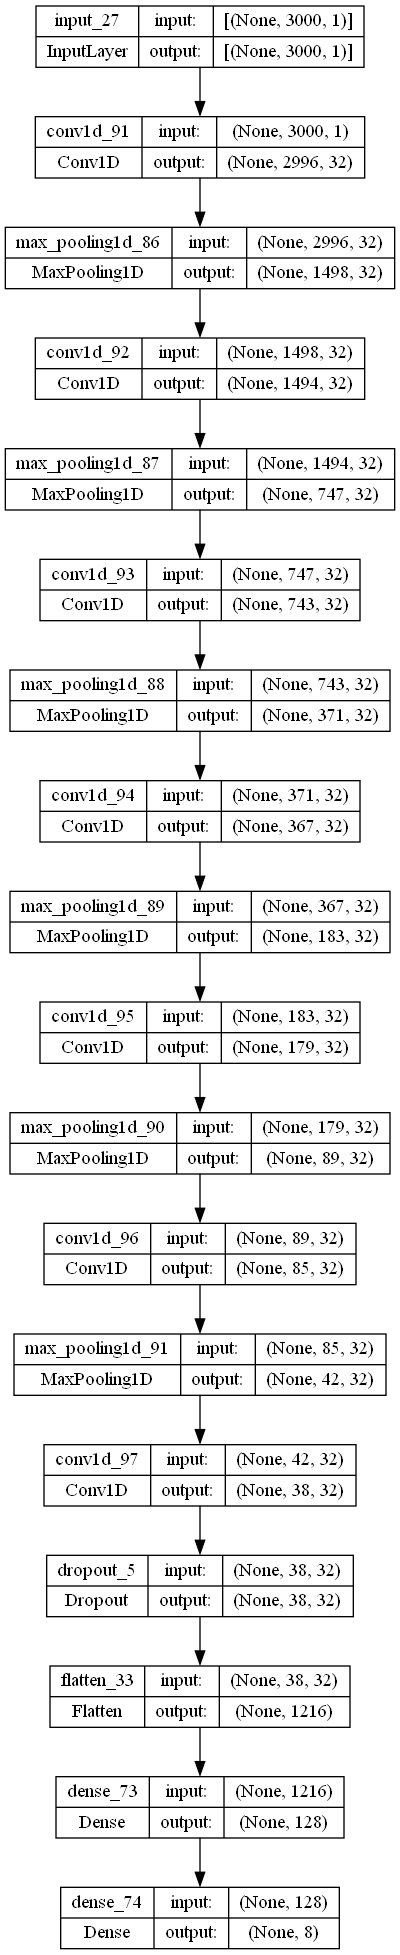

In [91]:
from keras.utils import plot_model
model2.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              # metrics=[tf.keras.metrics.CategoricalCrossentropy()])
              metrics=[tf.keras.metrics.CategoricalAccuracy()])
plot_model(model2, show_shapes=True, show_layer_names=True)

In [95]:
from tensorflow.keras.callbacks import ModelCheckpoint

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
checkpoint = ModelCheckpoint("best_model", monitor="val_categorical_accuracy", verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model2.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=EPOCHS, validation_steps=30, callbacks=[callbacks_list, es], verbose=1)

Epoch 1/15
234/235 [============================>.] - ETA: 0s - loss: 0.8560 - categorical_accuracy: 0.7106
Epoch 1: val_categorical_accuracy improved from -inf to 0.64760, saving model to best_model


INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets


235/235 [==============================] - 27s 116ms/step - loss: 0.8559 - categorical_accuracy: 0.7105 - val_loss: 1.1009 - val_categorical_accuracy: 0.6476
Epoch 2/15
234/235 [============================>.] - ETA: 0s - loss: 0.8386 - categorical_accuracy: 0.7165
Epoch 2: val_categorical_accuracy did not improve from 0.64760
235/235 [==============================] - 25s 108ms/step - loss: 0.8394 - categorical_accuracy: 0.7163 - val_loss: 1.1195 - val_categorical_accuracy: 0.6404
Epoch 3/15
234/235 [============================>.] - ETA: 0s - loss: 0.8198 - categorical_accuracy: 0.7228
Epoch 3: val_categorical_accuracy did not improve from 0.64760
235/235 [==============================] - 25s 108ms/step - loss: 0.8194 - categorical_accuracy: 0.7229 - val_loss: 1.1205 - val_categorical_accuracy: 0.6440
Epoch 4/15
234/235 [============================>.] - ETA: 0s - loss: 0.7827 - categorical_accuracy: 0.7388
Epoch 4: val_categorical_accuracy did not improve from 0.64760
235/235 [====

INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets


235/235 [==============================] - 27s 117ms/step - loss: 0.7762 - categorical_accuracy: 0.7316 - val_loss: 1.1429 - val_categorical_accuracy: 0.6496
Epoch 6/15
234/235 [============================>.] - ETA: 0s - loss: 0.7364 - categorical_accuracy: 0.7477
Epoch 6: val_categorical_accuracy did not improve from 0.64960
235/235 [==============================] - 26s 112ms/step - loss: 0.7368 - categorical_accuracy: 0.7477 - val_loss: 1.1609 - val_categorical_accuracy: 0.6344
Epoch 7/15
234/235 [============================>.] - ETA: 0s - loss: 0.7228 - categorical_accuracy: 0.7575
Epoch 7: val_categorical_accuracy did not improve from 0.64960
235/235 [==============================] - 26s 111ms/step - loss: 0.7231 - categorical_accuracy: 0.7575 - val_loss: 1.1371 - val_categorical_accuracy: 0.6472
Epoch 8/15
234/235 [============================>.] - ETA: 0s - loss: 0.7080 - categorical_accuracy: 0.7603
Epoch 8: val_categorical_accuracy did not improve from 0.64960
235/235 [====

# Zatial najlepsie:
    75.23 (rozsireny dataset - keras TextVectorization layer, LSTM)
    73.90 (rozsireny dataset - keras TextVectorization layer, LSTM)
    71.28 (rozsireny dataset - keras TextVectorization layer, LSTM)
    67.52 (rozsireny dataset - sklearn TextVectorization, Conv1D)

In [39]:
# Saving model
# pickle.dump(model, open("model", 'wb'))

In [45]:
# Load model
# model = pickle.load(open("model", 'rb'))

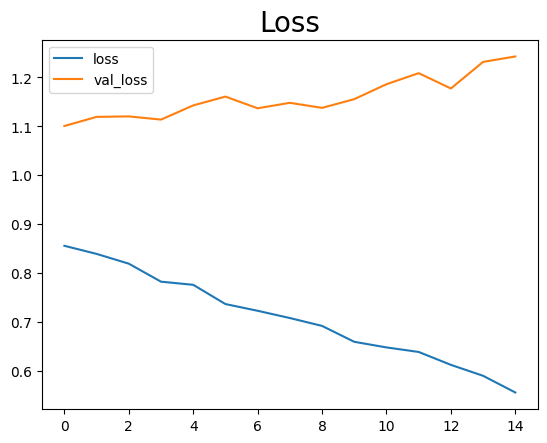

In [96]:
h = history.history

plt.plot(h["loss"], label="loss")
plt.plot(h["val_loss"], label="val_loss")
# plt.plot(h["val_loss"], label="val_loss")
plt.title("Loss", fontsize=20)
plt.legend()
plt.show()

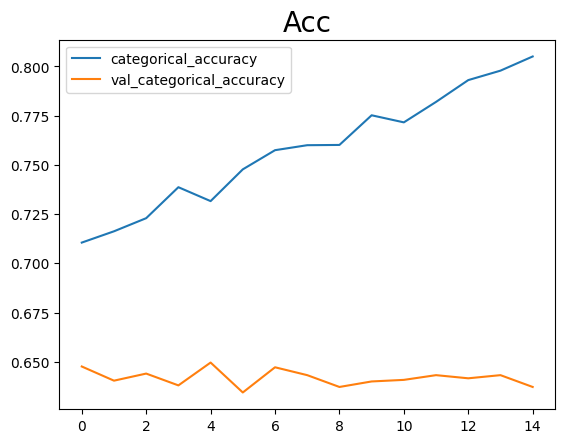

In [97]:
plt.plot(h["categorical_accuracy"], label="categorical_accuracy")
plt.plot(h["val_categorical_accuracy"], label="val_categorical_accuracy")
# plt.plot(h["val_loss"], label="val_loss")
plt.title("Acc", fontsize=20)
plt.legend()
plt.show()

In [48]:
# test_loss, test_acc = model.evaluate(gen_val)
test_loss, test_acc = model.evaluate(X_test, y_test)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

35/35 [==============================] - 12s 336ms/step - loss: 1.1401 - categorical_accuracy: 0.7228
Test Loss: 1.1401411294937134
Test Accuracy: 0.7228260636329651


In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

labels = df.columns
predictions = model.predict(X_test)
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(11,11))
disp.plot(ax=ax, cmap="Greens")
plt.title("Confusion matrix for individual characters", fontsize=20)
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("True", fontsize=14)
plt.show()

157/157 [==============================] - 6s 26ms/step


ValueError: Classification metrics can't handle a mix of multilabel-indicator and continuous-multioutput targets

In [ ]:
# Doterajsie vysledky

# Cely DS:
#   2 kategorie ("Company" a "Education"):
#       15 epoch:
#           Train Acc: 0.9663   Train Loss: 0.0858
#           Test Acc = 0.9286   Test Loss: 0.2270
#       20 epoch:
#           Train Acc: 0.9671   Train Loss: 0.0783
#           Test Acc = 0.9270   Test Loss: 0.2536
#       50 epoch:
#           Train Acc: 0.9738   Train Loss: 0.0609
#           Test Acc = 0.9167   Test Loss: 0.4088
#
#   8 kategorii:
#       70 epoch:
#           Train Acc: 0.82     Train Loss: ?
#           Test Acc: 0.611     Test Loss: ?
#       100 epoch:
#           Train Acc: 0.8647   Train Loss: 0.3846
#           Test Acc: 0.606     Test Loss: 3.0083
#       130 epoch:
#           Train Acc: 0.8856   Train Loss: 0.3287
#           Test Acc: 0.6014    Test Loss: 3.6702
#       150 epoch:
#           Train Acc: 0.8898   Train Loss: 0.3170
#           Test Acc: 0.5954    Test Loss: 3.7761